# Calibration of non-isoplanatic low frequency data

This uses an implementation of the SageCAL algorithm to calibrate a simulated SKA1LOW observation in which sources inside the primary beam have one set of calibration errors and sources outside have different errors.

In this example, the peeler sources are held fixed in strength and location and only the gains solved. The other sources, inside the primary beam, are partitioned into weak (<5Jy) and strong (>5Jy). The weak sources are processed collectively as an image. The bright sources are processed individually.


In [1]:
% matplotlib inline

import os
import sys

sys.path.append(os.path.join('..', '..'))

from data_models.parameters import arl_path

results_dir = arl_path('test_results')

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from data_models.memory_data_models import SkyModel
from data_models.polarisation import PolarisationFrame

from processing_components.component_support.arlexecute import arlexecute

from processing_components.skycomponent.operations import find_skycomponents
from processing_components.calibration.calibration import solve_gaintable
from processing_components.calibration.operations import apply_gaintable, create_gaintable_from_blockvisibility
from processing_components.visibility.base import create_blockvisibility, copy_visibility
from processing_components.image.deconvolution import restore_cube
from processing_components.skycomponent.operations import select_components_by_separation, insert_skycomponent, \
    select_components_by_flux
from processing_components.image.operations import show_image, qa_image, copy_image, create_empty_image_like
from processing_components.util.testing_support import create_named_configuration, create_low_test_beam, \
    simulate_gaintable, create_low_test_skycomponents_from_gleam
from processing_components.skycomponent.operations import apply_beam_to_skycomponent, find_skycomponent_matches
from processing_components.imaging.base import create_image_from_visibility, advise_wide_field, \
    predict_skycomponent_visibility
from processing_components.imaging.imaging_functions import invert_function

from processing_components.components.calskymodel_components import calskymodel_solve_component

from processing_components.component_support.dask_init import get_dask_Client
from processing_components.image.operations import export_image_to_fits

import logging

def init_logging():
    log = logging.getLogger()
    logging.basicConfig(filename='%s/skymodel_cal.log' % results_dir,
                        filemode='a',
                        format='%(thread)s %(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.INFO)
log = logging.getLogger()
logging.info("Starting skymodel_cal")


Use Dask throughout

In [2]:
arlexecute.set_client(get_dask_Client())
arlexecute.client.run(init_logging)

Creating LocalCluster and Dask Client
<Client: scheduler='tcp://127.0.0.1:54689' processes=8 cores=8>
Diagnostic pages available on port http://127.0.0.1:54690


{'tcp://127.0.0.1:54700': None,
 'tcp://127.0.0.1:54703': None,
 'tcp://127.0.0.1:54704': None,
 'tcp://127.0.0.1:54712': None,
 'tcp://127.0.0.1:54714': None,
 'tcp://127.0.0.1:54715': None,
 'tcp://127.0.0.1:54718': None,
 'tcp://127.0.0.1:54730': None}

We make the visibility. The parameter rmax determines the distance of the furthest antenna/stations used. All over parameters are determined from this number.

We set the w coordinate to be zero for all visibilities so as not to have to do full w-term processing. This speeds up the imaging steps.

In [3]:
nfreqwin = 1
ntimes = 1
rmax = 750
frequency = numpy.linspace(0.8e8, 1.2e8, nfreqwin)
if nfreqwin > 1:
    channel_bandwidth = numpy.array(nfreqwin * [frequency[1] - frequency[0]])
else:
    channel_bandwidth = [0.4e8]
times = numpy.linspace(-numpy.pi / 3.0, numpy.pi / 3.0, ntimes)

phasecentre=SkyCoord(ra=+30.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox='J2000')
lowcore = create_named_configuration('LOWBD2', rmax=rmax)

block_vis = create_blockvisibility(lowcore, times, frequency=frequency,
    channel_bandwidth=channel_bandwidth, weight=1.0, phasecentre=phasecentre,
    polarisation_frame=PolarisationFrame("stokesI"), zerow=True)

In [4]:
wprojection_planes=1
advice=advise_wide_field(block_vis, guard_band_image=5.0, delA=0.02, 
                         wprojection_planes=wprojection_planes)

vis_slices = advice['vis_slices']
npixel=advice['npixels2']
cellsize=advice['cellsize']

Generate the model from the GLEAM catalog, including application of the primary beam.

Number of components 53


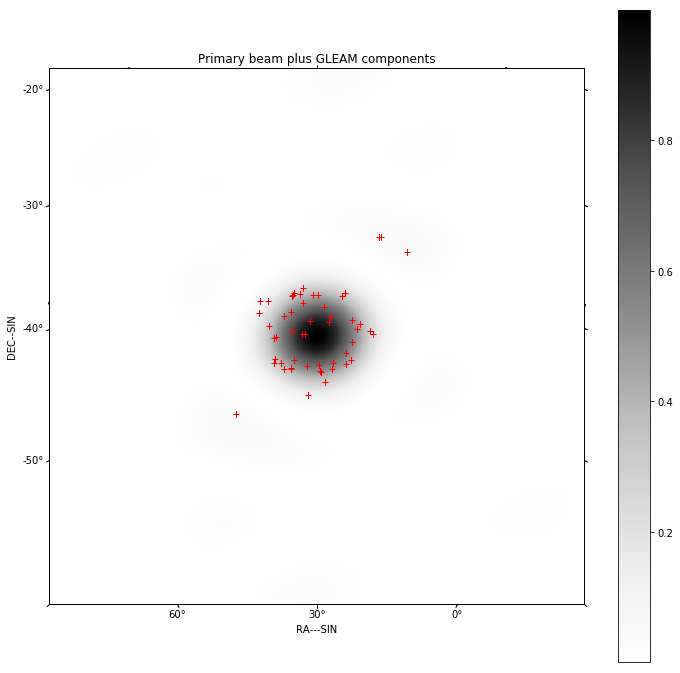

In [5]:
beam = create_image_from_visibility(block_vis, npixel=npixel, frequency=frequency,
    nchan=nfreqwin, cellsize=cellsize, phasecentre=phasecentre)

original_gleam_components = create_low_test_skycomponents_from_gleam(flux_limit=1.0,
    phasecentre=phasecentre, frequency=frequency, 
    polarisation_frame=PolarisationFrame('stokesI'),
    radius=npixel * cellsize/2.0)

beam = create_low_test_beam(beam)
pb_gleam_components = apply_beam_to_skycomponent(original_gleam_components, beam, 
                                                       flux_limit=0.5)
from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'


show_image(beam, components=pb_gleam_components, cm='Greys', title='Primary beam plus GLEAM components')
print("Number of components %d" % len(pb_gleam_components))

Generate the template image

In [6]:
model = create_image_from_visibility(block_vis, npixel=npixel, 
                                     frequency=[numpy.average(frequency)], 
                                     nchan=1,
                                     channel_bandwidth=[numpy.sum(channel_bandwidth)], 
                                     cellsize=cellsize, phasecentre=phasecentre)

Create sources to be peeled

In [7]:
peel_distance = 0.16
peelers = select_components_by_separation(phasecentre, pb_gleam_components, 
                                          min=peel_distance)
gleam_components = select_components_by_separation(phasecentre, pb_gleam_components, 
                                          max=peel_distance)
print("There are %d sources inside the primary beam and %d sources outside"
     % (len(gleam_components), len(peelers)))

There are 49 sources inside the primary beam and 4 sources outside


Create the model visibilities, applying a different gain table for peeled sources and other components

Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: '(1, 1, 768, 768)'
		max: '9.81387789659001'
		min: '-0.328172750563994'
		rms: '0.12489006510198261'
		sum: '-92.41309207550174'
		medianabs: '0.05910143215682258'
		median: '-0.00996756898755585'



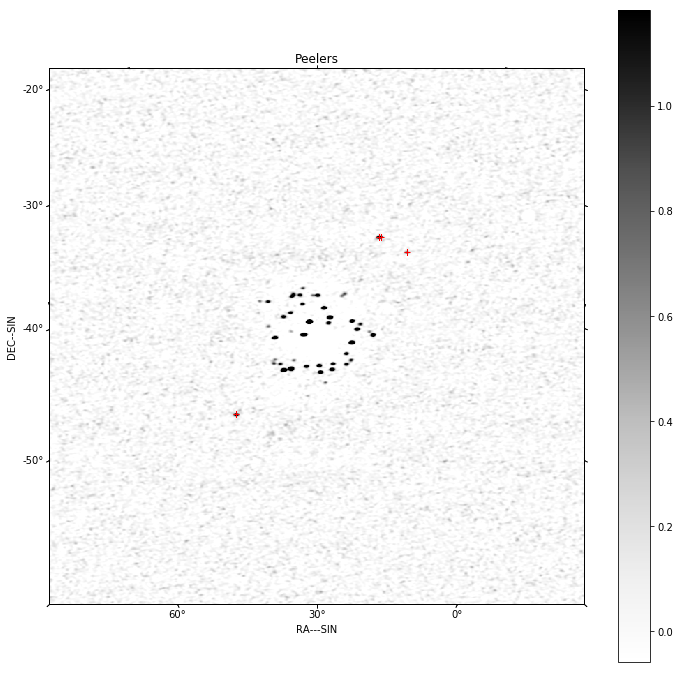

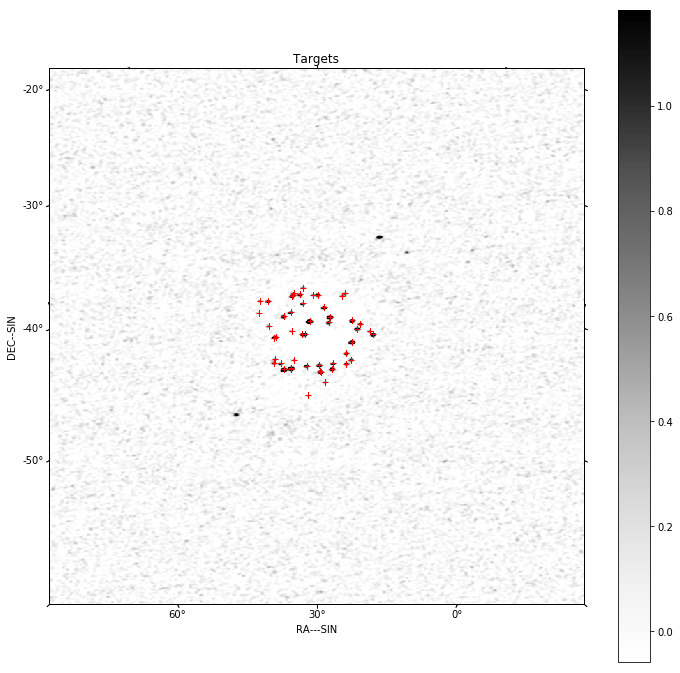

In [8]:
corrupted_vis = copy_visibility(block_vis, zero=True)
gt = create_gaintable_from_blockvisibility(block_vis, timeslice='auto')

components_errors = [(p, 1.0) for p in peelers]
components_errors.append((pb_gleam_components, 0.1))

for sc, phase_error in components_errors:
    component_vis = copy_visibility(block_vis, zero=True)
    gt = simulate_gaintable(gt, amplitude_error=0.0, phase_error=phase_error)
    component_vis = predict_skycomponent_visibility(component_vis, sc)
    component_vis = apply_gaintable(component_vis, gt)
    corrupted_vis.data['vis'][...]+=component_vis.data['vis'][...]
    
dirty, sumwt = invert_function(corrupted_vis, model, context='2d')
qa=qa_image(dirty)
vmax=qa.data['medianabs']*20.0
vmin=-qa.data['medianabs']
print(qa)
export_image_to_fits(dirty, '%s/calskymodel_before_dirty.fits' % results_dir)
show_image(dirty, cm='Greys', components=peelers, vmax=vmax, vmin=vmin, title='Peelers')
show_image(dirty, cm='Greys', components=gleam_components, vmax=vmax, vmin=vmin, title='Targets')
plt.show()

Find the components above the threshold

Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: '(1, 1, 768, 768)'
		max: '9.81387789659001'
		min: '-0.328172750563994'
		rms: '0.12489006510198261'
		sum: '-92.41309207550174'
		medianabs: '0.05910143215682258'
		median: '-0.00996756898755585'

Selecting sources brighter than 0.591014


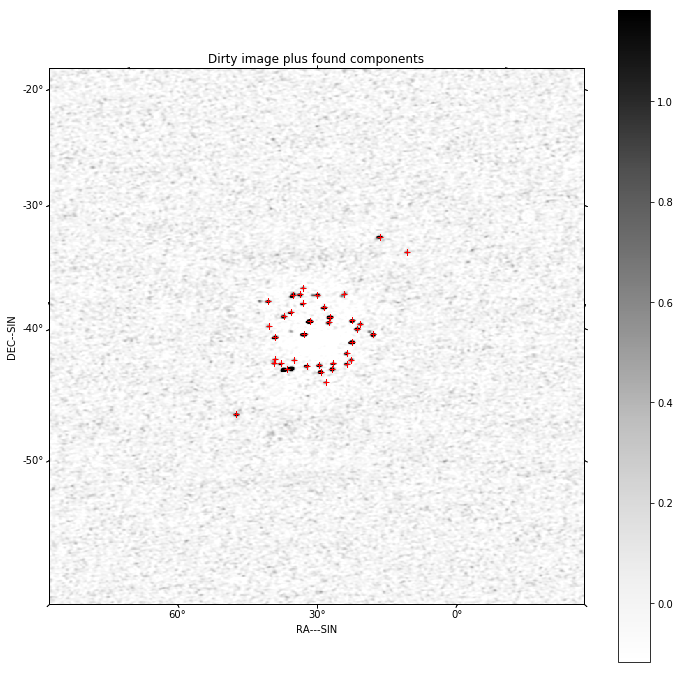

In [9]:
qa = qa_image(dirty)
vmax=qa.data['medianabs']*20.0
vmin=-qa.data['medianabs']*2.0
print(qa)
threshold = 10.0*qa.data['medianabs']
print("Selecting sources brighter than %f" % threshold)
initial_found_components= find_skycomponents(dirty, threshold=threshold)
show_image(dirty, components=initial_found_components, cm='Greys', vmax=vmax, vmin=vmin,
           title='Dirty image plus found components')
plt.show()

3 sources will be peeled (i.e. held fixed but gain solved)
3 bright sources will be processed as components (solved both as component and for gain)
32 faint sources will be processed collectively as a fixed image and gain solved


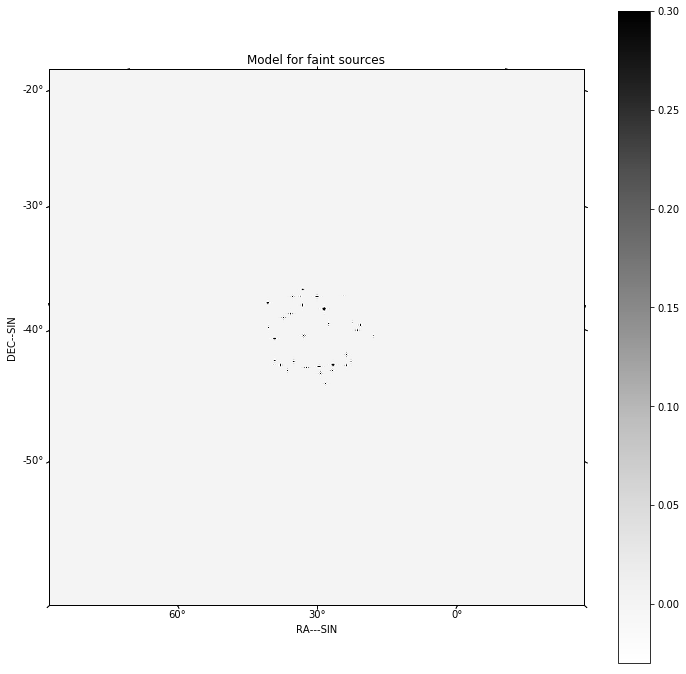

In [10]:
peel_distance = 0.16
flux_threshold=5.0
peelers = select_components_by_separation(phasecentre, initial_found_components, 
                                          min=peel_distance)

inbeam_components = select_components_by_separation(phasecentre, initial_found_components, 
                                          max=peel_distance)

bright_components = select_components_by_flux(inbeam_components, fmin=flux_threshold)
faint_components = select_components_by_flux(inbeam_components, fmax=flux_threshold)

print("%d sources will be peeled (i.e. held fixed but gain solved)" % len(peelers))
print("%d bright sources will be processed as components (solved both as component and for gain)" % len(bright_components))
print("%d faint sources will be processed collectively as a fixed image and gain solved" % len(faint_components))

faint_model = create_empty_image_like(model)
faint_model = insert_skycomponent(faint_model, faint_components, insert_method='Lanczos')

show_image(faint_model,  cm='Greys', title='Model for faint sources', vmax=0.3, vmin=-0.03)
plt.show()
                  
calskymodel_graph = [arlexecute.execute(SkyModel, nout=1)(components=[p], fixed=True) for p in peelers] \
    + [arlexecute.execute(SkyModel, nout=1)(components=[b], fixed=False) for b in bright_components] \
    + [arlexecute.execute(SkyModel, nout=1)(images=[faint_model], fixed=True)]

Run skymodel_cal using dask

In [11]:
corrupted_vis = arlexecute.scatter(corrupted_vis)
graph = calskymodel_solve_component(corrupted_vis, calskymodel_graph, niter=30, gain=0.25, tol=1e-8)
calskymodel, residual_vis = arlexecute.compute(graph, sync=True)

arlexecute.compute: Synchronous execution took 192.075 seconds


Combine all components for display

In [12]:
skymodel_components = list()
for csm in calskymodel:
    skymodel_components += csm[0].components

Check that the peeled sources are not altered

In [13]:
recovered_peelers = find_skycomponent_matches(peelers, skymodel_components, 1e-5)
ok = True
for p in recovered_peelers:
    ok = ok and numpy.abs(peelers[p[0]].flux[0,0] - skymodel_components[p[1]].flux[0,0]) < 1e-7
print("Peeler sources flux unchanged: %s" % ok)
ok = True
for p in recovered_peelers:
    ok = ok and peelers[p[0]].direction.separation(skymodel_components[p[1]].direction).rad < 1e-15
print("Peeler sources directions unchanged: %s" % ok)

Peeler sources flux unchanged: True
Peeler sources directions unchanged: True


Now we find the components in the residual image and add those to the existing model

Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: '(1, 1, 768, 768)'
		max: '4.151985846320881'
		min: '-0.25041324260993614'
		rms: '0.04386648294380961'
		sum: '-19.031612200628018'
		medianabs: '0.021086466459909713'
		median: '-0.004717281833586808'

Selecting sources brighter than 0.421729


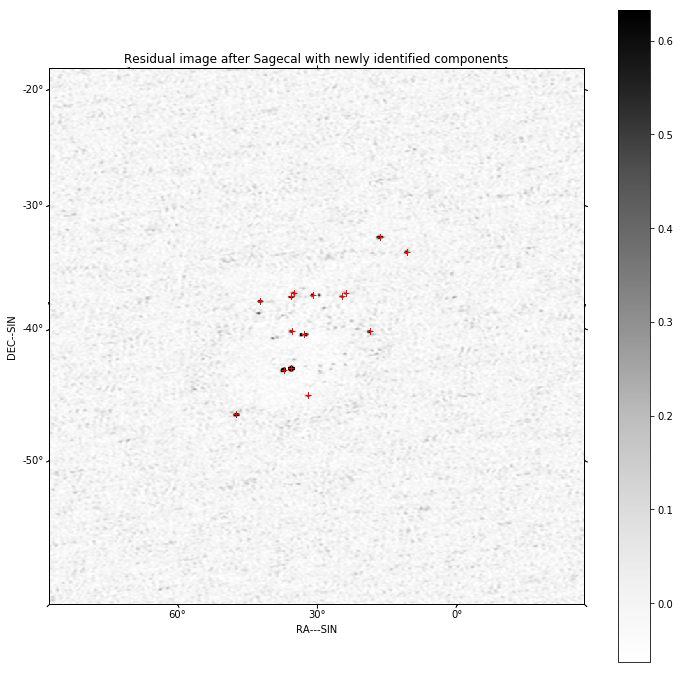

In [14]:
residual, sumwt = invert_function(residual_vis, model, context='2d')
qa = qa_image(residual)
vmax=qa.data['medianabs']*30.0
vmin=-qa.data['medianabs']*3.0
print(qa)
threshold = 20.0*qa.data['medianabs']
print("Selecting sources brighter than %f" % threshold)

final_found_components = find_skycomponents(residual, threshold=threshold)
show_image(residual, components=final_found_components, cm='Greys', 
           title='Residual image after Sagecal with newly identified components', vmax=vmax, vmin=vmin)

plt.show()

final_components= skymodel_components + final_found_components

Make a restored image

Quality assessment:
	Origin: qa_image
	Context: Restored image after SageCal
	Data:
		shape: '(1, 1, 768, 768)'
		max: '10.127844057092542'
		min: '-0.10365173076803387'
		rms: '0.12951752649739037'
		sum: '3855.1546404734727'
		medianabs: '0.02121311358838955'
		median: '-0.004346665282976491'



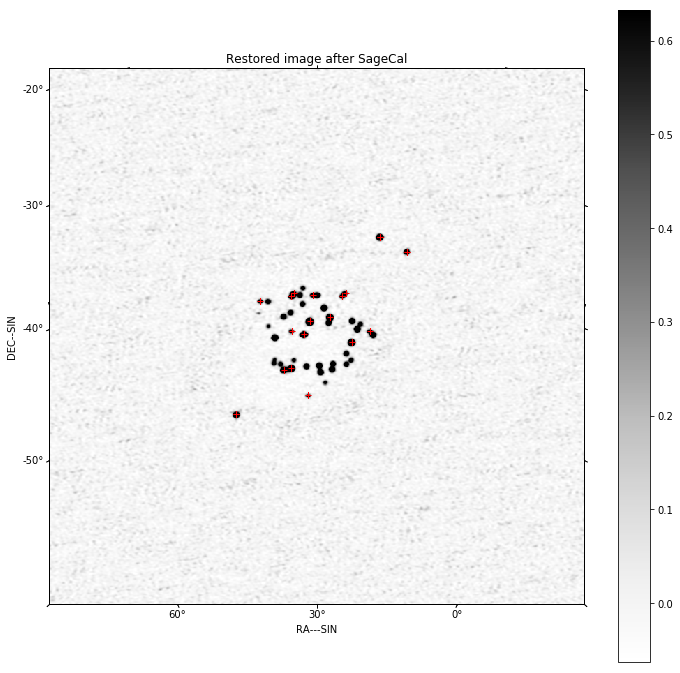

In [15]:
psf, _ = invert_function(residual_vis, model, dopsf=True, context='2d')

component_image = copy_image(faint_model)
component_image = insert_skycomponent(component_image, final_components)
restored = restore_cube(component_image, psf, residual)
export_image_to_fits(restored, '%s/calskymodel_restored.fits' % results_dir)

qa=qa_image(restored, context='Restored image after SageCal')
print(qa)

show_image(restored, components=final_components, cm='Greys', 
           title='Restored image after SageCal', vmax=vmax, vmin=vmin)
plt.show()

Now match the recovered components to the originals

In [16]:
original_bright_components = peelers + bright_components
matches = find_skycomponent_matches(final_components, original_bright_components, 3*cellsize)

Look at the range of separations found

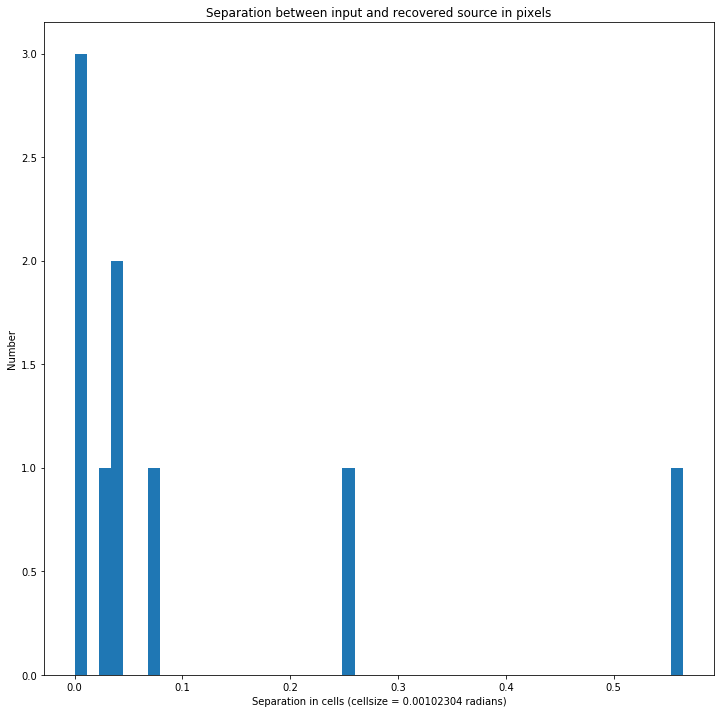

In [17]:
separations = [match[2] for match in matches]
plt.clf()
plt.hist(separations/cellsize, bins=50)
plt.title('Separation between input and recovered source in pixels')
plt.xlabel('Separation in cells (cellsize = %g radians)' % cellsize)
plt.ylabel('Number')
plt.show()

Now look at the matches between the original components and those recovered.

In [18]:
totalfluxin = numpy.sum([c.flux[0,0] for c in pb_gleam_components]) 
totalfluxout = numpy.sum([c.flux[0,0] for c in final_components]) + numpy.sum(faint_model.data)
print("Recovered %.3f (Jy) of original %.3f (Jy)" % (totalfluxout, totalfluxin))
found = [match[1] for match in matches]
notfound = list()
for c in range(len(original_bright_components)):
    if c not in found:
        notfound.append(c)
        
print("The following original components were not found", notfound)

Recovered 105.130 (Jy) of original 109.996 (Jy)
The following original components were not found []


Look at the recovered flux and the location of the unmatched components. From the image display these seem to be blends of close components.

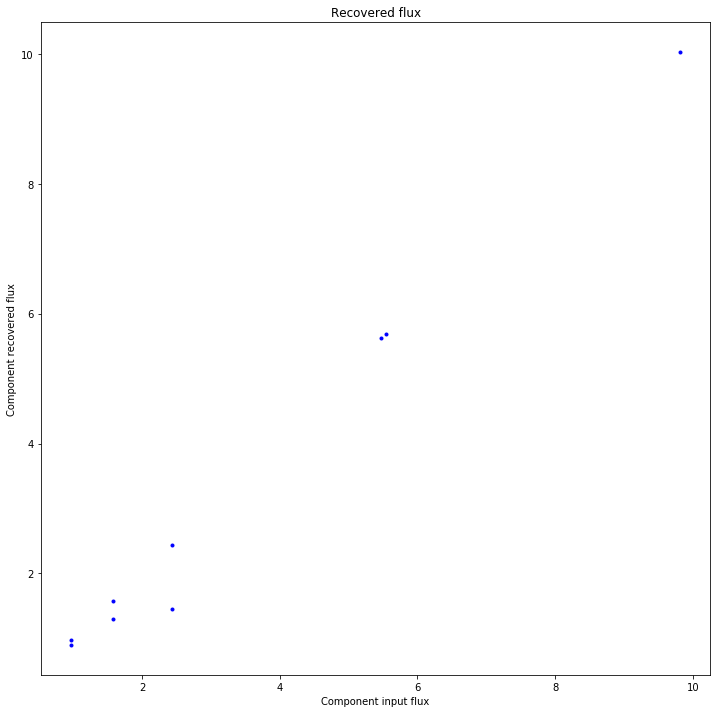

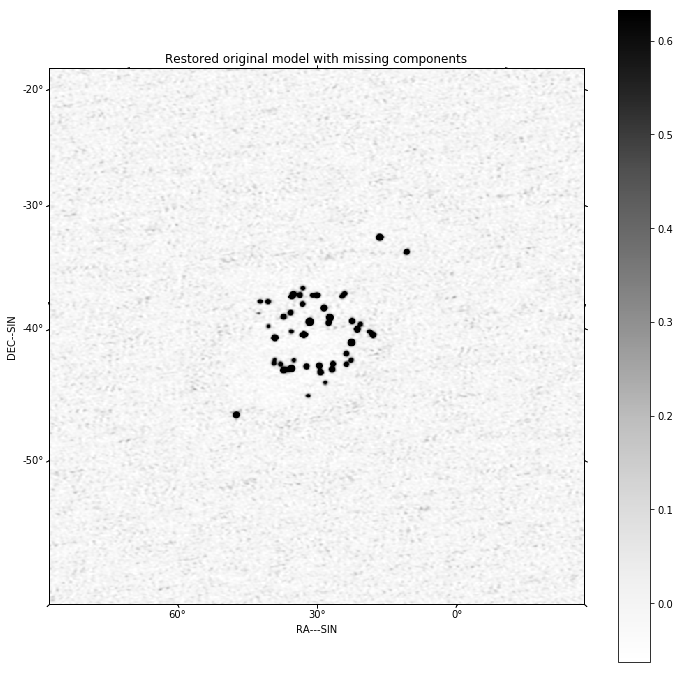

In [19]:
fluxin = [original_bright_components[match[1]].flux[0,0] for match in matches]
fluxout = [final_components[match[0]].flux[0,0] for match in matches]
missed_components = [original_bright_components[c] for c in notfound]
missed_flux = [match.flux[0,0] for match in missed_components]
    
plt.clf()
plt.plot(fluxin, fluxout, '.', color='blue')
plt.plot(missed_flux, len(missed_flux)*[0.0], '.', color='red')

plt.title('Recovered flux')
plt.xlabel('Component input flux')
plt.ylabel('Component recovered flux')
plt.show()

show_image(restored, components=missed_components, cm='Greys', 
           title='Restored original model with missing components', vmax=vmax, vmin=vmin)
plt.show()
